# Two-Operand Addition Benchmarking Baseline Performance

In [61]:
import re
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np

In [62]:
sns.set_theme()
sns.set_style("whitegrid")
plt.style.use("alan.mplstyle")
ROOT = Path("../src/logic/data")

In [65]:
da = pickle.load(open(ROOT / "gemma-add-baseline-benchmark.pkl", "rb"))

In [66]:
def parse_ans(s):
    splits = s.split("\n")
    prob = splits[3]
    prob = prob.split("=")
    a, b = prob[0].split("+")
    try:
        return (int(a), int(b), int(prob[1]))
    except:
        return (int(a), int(b), -10)

def get_accuracy_add(points):
    correct = [a[0] + a[1] == a[2] for a in points]
    return sum(correct) / len(points)

In [67]:
parsed = {k : list(map(parse_ans, v)) for k, v in da.items()}

In [68]:
accuracy = {k : get_accuracy_add(v) for k, v in parsed.items()}

In [69]:
accuracy

{(1, 1): 0.913,
 (1, 2): 0.87,
 (1, 3): 0.775,
 (1, 4): 0.794,
 (1, 5): 0.809,
 (1, 6): 0.827,
 (1, 7): 0.739,
 (1, 8): 0.7,
 (2, 1): 0.913,
 (2, 2): 0.927,
 (2, 3): 0.825,
 (2, 4): 0.675,
 (2, 5): 0.57,
 (2, 6): 0.463,
 (2, 7): 0.426,
 (2, 8): 0.282,
 (3, 1): 0.891,
 (3, 2): 0.83,
 (3, 3): 0.862,
 (3, 4): 0.768,
 (3, 5): 0.607,
 (3, 6): 0.393,
 (3, 7): 0.35,
 (3, 8): 0.325,
 (4, 1): 0.917,
 (4, 2): 0.797,
 (4, 3): 0.762,
 (4, 4): 0.834,
 (4, 5): 0.671,
 (4, 6): 0.45,
 (4, 7): 0.191,
 (4, 8): 0.275,
 (5, 1): 0.894,
 (5, 2): 0.778,
 (5, 3): 0.713,
 (5, 4): 0.667,
 (5, 5): 0.73,
 (5, 6): 0.426,
 (5, 7): 0.236,
 (5, 8): 0.065,
 (6, 1): 0.837,
 (6, 2): 0.694,
 (6, 3): 0.61,
 (6, 4): 0.573,
 (6, 5): 0.584,
 (6, 6): 0.652,
 (6, 7): 0.218,
 (6, 8): 0.066,
 (7, 1): 0.766,
 (7, 2): 0.608,
 (7, 3): 0.481,
 (7, 4): 0.325,
 (7, 5): 0.281,
 (7, 6): 0.269,
 (7, 7): 0.465,
 (7, 8): 0.067,
 (8, 1): 0.675,
 (8, 2): 0.423,
 (8, 3): 0.338,
 (8, 4): 0.306,
 (8, 5): 0.083,
 (8, 6): 0.032,
 (8, 7): 0.059,
 

In [70]:
grid = np.zeros((8,8))

In [71]:
for k, v in accuracy.items():
    grid[k[0]-1,k[1]-1] = v

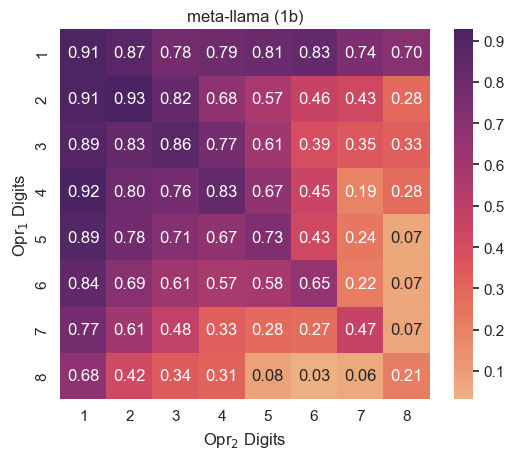

In [72]:
ax = sns.heatmap(grid, cmap="flare", annot=True, fmt=".2f", square=True, cbar=True)
ax.set_xticklabels(range(1,9))
ax.set_yticklabels(range(1,9))
ax.set_title("meta-llama (1b)")
ax.set_ylabel("Opr$_1$ Digits")
ax.set_xlabel("Opr$_2$ Digits")
plt.savefig("gemma-2-add-benchmark.pdf")

In [17]:
d[(1,1)][0].split("\n")

['5 - 2 = 3', '1 - 3 = -2', '2 - 3 = 1', '3 - 1 = 2', '4 - 2 =']

In [79]:
da = {k: [1 if v[0] + v[1] == v[2] else 0 for v in j] for k, j in dp.items()} 

In [82]:
ds = {k: sum(v) / len(v) for k,v in da.items()}

In [84]:
pickle.dump(ds, open("gemma-2-2b-sub-acc.pkl", "wb"))